## In this assignment, we will implement a simple rule-based POS tagger

First let's download the universal dependency treebank from the following url https://lindat.mff.cuni.cz/repository/xmlui/handle/11234/1-4611

Create a folder named `data`. Copy the downloaded `ud-treebanks-v2.9.tgz` file into the current directory and untar it

let us import some libraries

In [1]:
import codecs
import random

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

Now let's write some utility functions

### Utility Code

#### Code to read data from CoNLL format

In [2]:
def conllReader(filename, word_field=1, label_field=3):
    sentences = []
    sentence = []
    label_list = []
    
    with codecs.open(filename, 'r', errors='ignore', encoding='utf8') as f_in:
        for line in f_in:
            line = line.strip()
            if line:
                if line.startswith('# '):
                    continue
                    
                word = line.split('\t')[word_field]
                label = line.split('\t')[label_field]
                
                tokens = [word, label]
                sentence.append( tokens )
                
                if label not in label_list:
                    label_list.append( label )
            else:
                if len(sentence) > 0:
                    sentences.append( sentence )
                sentence = []
        f_in.close()
        
    return sentences, label_list

In [3]:
train_split, label_list = conllReader('data/ud-treebanks-v2.9/UD_Tamil-TTB/ta_ttb-ud-train.conllu', word_field=1, label_field=3)

print('Read {0} number of train sentences'.format( len(train_split) ))
print('\nFirst sentence looks like')
print(train_split[0])

print('\n Labels used are')
print(label_list)

Read 400 number of train sentences

First sentence looks like
[['சென்னை', 'PROPN'], ['அருகே', 'ADP'], ['ஸ்ரீ', 'PROPN'], ['பெரும்புதூரில்', 'PROPN'], ['கிரீன்', 'PROPN'], ['பீல்டு', 'PROPN'], ['(', 'PUNCT'], ['நவீன', 'ADJ'], [')', 'PUNCT'], ['விமான', 'PROPN'], ['நிலையத்துக்குக்கான', '_'], ['நிலையத்துக்குக்க்', 'NOUN'], ['ஆன', 'PART'], ['நிலம்', 'NOUN'], ['யாருக்கும்', 'PRON'], ['பாதிப்பு', 'NOUN'], ['இல்லாத', 'ADP'], ['வகையில்', 'NOUN'], ['எடுக்கப்', 'VERB'], ['படும்', 'AUX'], ['என்று', 'PART'], ['முதல்வர்', 'NOUN'], ['கருணாநிதி', 'PROPN'], ['உறுதியளித்துள்ளார்', '_'], ['உறுதியளித்த்', 'VERB'], ['உள்ளார்', 'AUX'], ['.', 'PUNCT']]

 Labels used are
['PROPN', 'ADP', 'PUNCT', 'ADJ', '_', 'NOUN', 'PART', 'PRON', 'VERB', 'AUX', 'ADV', 'DET', 'CCONJ', 'NUM']


In [4]:
def getMax(dictionary):    
    max_key = list(dictionary.keys())[0]
    max_value = dictionary[max_key]
    for key in dictionary:
        if max_value > dictionary[key]:
            max_value = dictionary[key]
            max_key = key
            
    return key

Now we have the data loading part written, let's write a simple Most-Frequent POS tagger 

### Most Frequent POS Tagger

Let's load the train and test sets

In [5]:
train_split, label_list = conllReader('data/ud-treebanks-v2.9/UD_Tamil-TTB/ta_ttb-ud-train.conllu', word_field=1, label_field=3)
test_split, test_label_list = conllReader('data/ud-treebanks-v2.9/UD_Tamil-TTB/ta_ttb-ud-test.conllu', word_field=1, label_field=3)

print('Read {0} number of train sentences'.format( len(train_split) ))
print('Label list in train split is')
print(label_list)

print('\n' * 2)
print('Read {0} number of test sentences'.format( len(test_split) ))
print('Label list in test split is')
print(test_label_list)

combined_label_list = list( set( label_list + test_label_list ) )

Read 400 number of train sentences
Label list in train split is
['PROPN', 'ADP', 'PUNCT', 'ADJ', '_', 'NOUN', 'PART', 'PRON', 'VERB', 'AUX', 'ADV', 'DET', 'CCONJ', 'NUM']



Read 120 number of test sentences
Label list in test split is
['_', 'PROPN', 'ADP', 'ADJ', 'NOUN', 'VERB', 'AUX', 'PUNCT', 'ADV', 'PRON', 'PART', 'NUM', 'DET', 'CCONJ', 'X']


For every word in train split, let's get the POS statistics

In [6]:
word_pos_frequency = {}

for every_sentence in train_split:
    for every_token in every_sentence:
        word, label = every_token
        if word in word_pos_frequency:
            if label in word_pos_frequency[word]:
                word_pos_frequency[word][label] += 1
            else:
                word_pos_frequency[word][label] = 1
        else:
            word_pos_frequency[word] = {}
            word_pos_frequency[word][label] = 1
            
print('Total number of words in train split is {0}'.format( len(word_pos_frequency) ) )
first_word = next(iter(word_pos_frequency))
print( 'Word is {0}'.format(first_word) )
print( word_pos_frequency[first_word] )

Total number of words in train split is 3040
Word is சென்னை
{'PROPN': 7}


In [7]:
count = 1
for every_word in word_pos_frequency:
    if len( word_pos_frequency[every_word] ) > 1:
        if count == 1:
            count += 1
            continue
        print( 'Word is {0}'.format(every_word) )
        print( word_pos_frequency[every_word] )
        break

Word is படும்
{'AUX': 1, 'ADJ': 2}


### Evaluate on test split

In [8]:
ground_truth = []
prediction = []

total_num_tokens = 0
tokens_present_in_train = 0

for every_sentence in test_split:
    ground_truth_sentence = []
    prediction_sentence = []

    for every_token in every_sentence:
        word, label = every_token
        ground_truth_sentence.append( label )
        
        total_num_tokens += 1

        if word in word_pos_frequency:
            tokens_present_in_train += 1
            prediction_sentence.append( getMax( word_pos_frequency[word] ) )
        else:
            prediction_sentence.append( random.choice( label_list ) )
            
    ground_truth.append( ground_truth_sentence )
    prediction.append( prediction_sentence )
    
print("Out of {0} number of words in test split, {1} appeared in train split".format( total_num_tokens, tokens_present_in_train ))

Out of 2183 number of words in test split, 1215 appeared in train split


In [9]:
flatten_gold_truth = [j for sub in ground_truth for j in sub]
flatten_predictions = [j for sub in prediction for j in sub]

print(classification_report(flatten_gold_truth, flatten_predictions, target_names=combined_label_list, digits=4))

              precision    recall  f1-score   support

        PRON     0.1842    0.5283    0.2732        53
           _     0.2373    0.4118    0.3011        68
         DET     0.3009    0.4533    0.3617        75
       CCONJ     0.5138    0.6159    0.5602       151
         NUM     0.0920    1.0000    0.1684         8
         ADP     0.2976    0.8621    0.4425        29
         ADJ     0.8007    0.4125    0.5445       526
        VERB     0.4245    0.4945    0.4569        91
           X     0.6273    0.8214    0.7113       168
        NOUN     0.4154    0.8852    0.5654        61
        PART     0.6159    0.4056    0.4891       249
       PUNCT     0.7308    1.0000    0.8444       190
       PROPN     0.5363    0.3009    0.3855       319
         ADV     0.0000    0.0000    0.0000         1
         AUX     0.4407    0.2680    0.3333       194

    accuracy                         0.5080      2183
   macro avg     0.4145    0.5640    0.4292      2183
weighted avg     0.5839   

/Users/rudra/anaconda3/envs/nlplab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rudra/anaconda3/envs/nlplab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rudra/anaconda3/envs/nlplab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

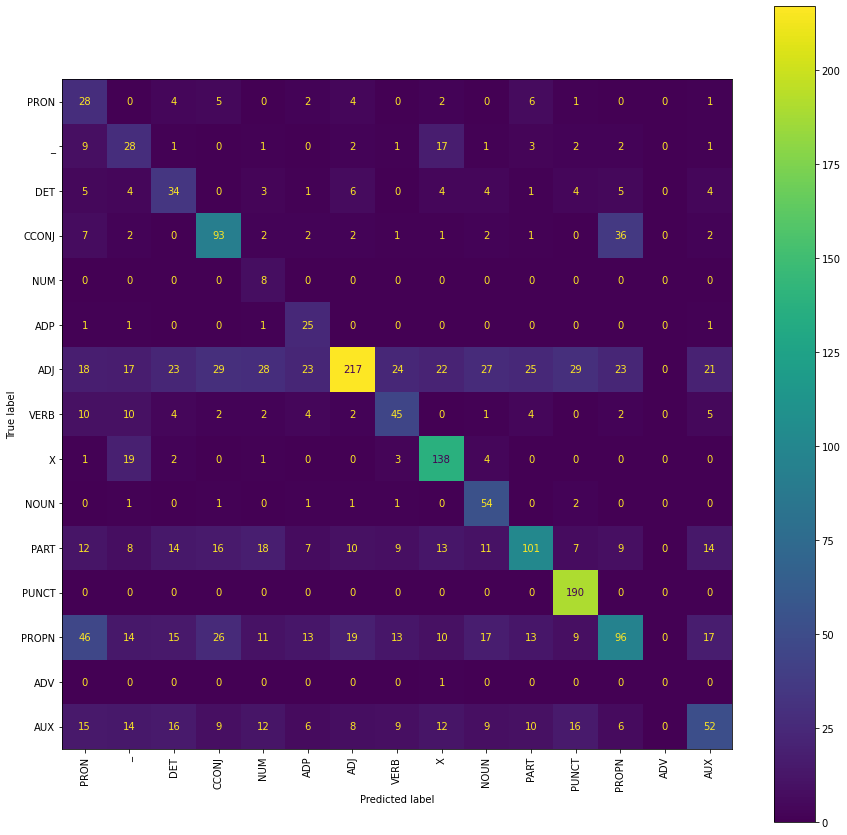

In [10]:
cm = confusion_matrix(flatten_gold_truth, flatten_predictions)

cmd = ConfusionMatrixDisplay(cm, display_labels=combined_label_list)

fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)

cmd.plot(xticks_rotation='vertical', ax =ax)

In [ ]:
    
# For tasks requiring phrase-level annotation
# from seqeval.metrics import accuracy_score
# from seqeval.metrics import classification_report
# from seqeval.metrics import f1_score
# from seqeval.scheme import IOB1
# print('F1 Score is')
# print( f1_score(ground_truth, prediction) )

# print('Classification report')
# print( classification_report(ground_truth, prediction, scheme=IOB1) )

## Implement Rule-based System here

Let us write a simple rule to tag adverbs

In [11]:
affix_pos_frequency = {}

for every_word in word_pos_frequency:
    if len(every_word) > 5:
        quad_gram_character = every_word[ -4: ]
        
        if quad_gram_character in affix_pos_frequency:
            for key in word_pos_frequency[ every_word ]:
                if key in affix_pos_frequency[quad_gram_character]:
                    affix_pos_frequency[quad_gram_character][key] += word_pos_frequency[ every_word ][key]
                else:
                    affix_pos_frequency[quad_gram_character][key] = word_pos_frequency[ every_word ][key]
        else:
            affix_pos_frequency[quad_gram_character] = word_pos_frequency[every_word]
    elif len(every_word) > 4:
        tri_gram_character = every_word[ -3: ]
        if tri_gram_character in affix_pos_frequency:
            for key in word_pos_frequency[ every_word ]:
                if key in affix_pos_frequency[tri_gram_character]:
                    affix_pos_frequency[tri_gram_character][key] += word_pos_frequency[ every_word ][key]
                else:
                    affix_pos_frequency[tri_gram_character][key] = word_pos_frequency[ every_word ][key]
        else:
            affix_pos_frequency[tri_gram_character] = word_pos_frequency[every_word]
    elif len(every_word) > 3:
        bi_gram_character = every_word[ -2: ]
        if bi_gram_character in affix_pos_frequency:
            for key in word_pos_frequency[ every_word ]:
                if key in affix_pos_frequency[bi_gram_character]:
                    affix_pos_frequency[bi_gram_character][key] += word_pos_frequency[ every_word ][key]
                else:
                    affix_pos_frequency[bi_gram_character][key] = word_pos_frequency[ every_word ][key]
        else:
            affix_pos_frequency[bi_gram_character] = word_pos_frequency[every_word]
            
        


In [14]:
ground_truth = []
prediction = []

for every_sentence in test_split:
    ground_truth_sentence = []
    prediction_sentence = []

    word_index = 0
    for every_token in every_sentence:
        word_index = word_index + 1
        word, label = every_token
        ground_truth_sentence.append( label )
        
        word_bi_gram = None
        word_tri_gram = None
        word_quad_gram = None
        
        if len(every_word) > 3:
            word_bi_gram = every_token[0][-2:]
        elif len(every_word) > 4:
            word_tri_gram = every_token[0][-3:]
        elif len(every_word) > 5:
            word_quad_gram = every_token[0][-4:]
        
        if word in word_pos_frequency:
            prediction_sentence.append( getMax( word_pos_frequency[word] ) )
        elif word_tri_gram in affix_pos_frequency:
            prediction_sentence.append( getMax( affix_pos_frequency[word_tri_gram] ) )
        elif word_bi_gram in affix_pos_frequency:
            prediction_sentence.append( getMax( affix_pos_frequency[word_bi_gram] ) )
        else:
            prediction_sentence.append( random.choice( combined_label_list ) )

    ground_truth.append( ground_truth_sentence )
    prediction.append( prediction_sentence )

In [15]:
flatten_gold_truth = [j for sub in ground_truth for j in sub]
flatten_predictions = [j for sub in prediction for j in sub]

print(classification_report(flatten_gold_truth, flatten_predictions, target_names=combined_label_list, digits=4))

              precision    recall  f1-score   support

        PRON     0.1701    0.6226    0.2672        53
           _     0.2000    0.3676    0.2591        68
         DET     0.5152    0.4533    0.4823        75
       CCONJ     0.3409    0.4967    0.4043       151
         NUM     0.0000    0.0000    0.0000         8
         ADP     0.2857    0.2759    0.2807        29
         ADJ     0.7277    0.5741    0.6419       526
        VERB     0.6167    0.4066    0.4901        91
           X     0.7929    0.6607    0.7208       168
        NOUN     0.2327    0.6066    0.3364        61
        PART     0.4018    0.5341    0.4586       249
       PUNCT     0.9500    1.0000    0.9744       190
       PROPN     0.7460    0.2947    0.4225       319
         ADV     0.0000    0.0000    0.0000         1
         AUX     0.4494    0.2062    0.2827       194

    accuracy                         0.5126      2183
   macro avg     0.4286    0.4333    0.4014      2183
weighted avg     0.6015   